In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from system import *
import scqubits
import colorednoise as cn
from scipy.optimize import golden
class Hamiltonian:
    def __init__(self, phi_ex, Ej, Ec, trunc):
        self.phi_ex = phi_ex
        self.Ej = Ej * 2*np.pi
        self.Ec = Ec * 2*np.pi
        self.beta = 1
        self.N = 1
        self.sdim = 10
        self.cdim = 6
        self.epsilon =1e-6
        self.trunc = trunc
        self.total_dim = trunc[-1]*trunc[-2]
        self.get_H()
        self.get_H_der()
        self.get_noise_operator()
        self.get_projectors()
        
        

    def annihilation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),1)
    def creation(self, dim):
        return np.diag(np.sqrt(np.arange(1,dim)),-1)

        
    def get_indices(self, dims):
        """
        Convert a list of 2D indices to 1D indices based on given dimensions.
        
        Args:
            dims: List of two integers [N,K] specifying the dimensions to include
                 N is number of cavity states
                 K is number of SNAIL states
                 
        Returns:
            List of 1D indices corresponding to the 2D indices
        """
        N, K = dims
        indices_2d = []
        indices_1d = []
        
        # Generate all 2D indices and store indices outside truncation
        for n in range(self.sdim):
            for k in range(self.cdim):
                # Only add indices that are outside the truncation
                if n >= N or k >= K:
                    indices_2d.append(f"{n}{k}")
                    # Convert to 1D index using n*cdim + k
                    idx = n*self.cdim + k
                    indices_1d.append(idx)

        return indices_1d
        
    def remove_row_col(self, matrix, indices):
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square")
        
        # Convert single index to list if needed
        if isinstance(indices, (int, np.integer)):
            indices = [indices]
            
        # Convert to list if numpy array
        if isinstance(indices, np.ndarray):
            indices = indices.tolist()
            
        # Sort indices in descending order to avoid changing indices when deleting
        indices = sorted(indices, reverse=True)
        
        # Check if indices are valid
        if any(i < 0 or i >= matrix.shape[0] for i in indices):
            raise ValueError(f"All indices must be between 0 and {matrix.shape[0]-1}")
        
        # Remove rows and columns
        result = matrix.copy()
        for idx in indices:
            result = np.delete(np.delete(result, idx, axis=0), idx, axis=1)
            
        return result
    
    def truncate_matrix(self, matrix, trunc):
        indices = self.get_indices(trunc)
        return self.remove_row_col(matrix, indices)
    
    def get_H(self):
        #if we want to use scqubits, replace Hs,charge_op with the ones obtained from scqubits
        Hs,charge_op, phi_zpf, noise = SNAIL(self.phi_ex, self.beta, self.N, self.Ej, self.Ec)
        self.Hs = Hs
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()
        self.U1 = U
        self.Ud1 = Ud

        self.omega_c = evals[1]
        self.omega_s = evals[self.cdim]
        self.chi = evals[self.cdim+1] - evals[self.cdim] - evals[1]
        self.anh = evals[2*self.cdim] - 2*evals[self.cdim]
        self.phi_zpf = phi_zpf
        self.H, self.H_control = H,H_control
        self.noise = noise

        cavity_sigmax = np.zeros((self.cdim, self.cdim))
        cavity_sigmax[0,1] = 1
        cavity_sigmax[1,0] = 1
        sigmaxc = np.kron(np.eye(self.sdim), cavity_sigmax)
        self.sigmaxc = self.truncate_matrix(sigmaxc, self.trunc)
        squid_sigmax = np.zeros((self.sdim, self.sdim))
        squid_sigmax[0,1] = 1
        squid_sigmax[1,0] = 1
        sigmaxs = np.kron(squid_sigmax, np.eye(self.cdim))
        self.sigmaxs = self.truncate_matrix(sigmaxs, self.trunc)
    
    
        
    def get_H_der(self):
        original_phi = self.phi_ex
        Hs,charge_op, phi_zpf,noise = SNAIL(self.phi_ex+self.epsilon, self.beta, self.N, self.Ej, self.Ec)
        squid = [Hs,charge_op]
        cavity = scqubits.Oscillator(
            E_osc=5.226,
            truncated_dim = 6
        )
        Hc = np.diag(cavity.eigenvals() - cavity.eigenvals()[0])*2*np.pi
        Vc = cavity.creation_operator() + cavity.annihilation_operator()
        cavity = [Hc,Vc]
        H,H_control,noise = composite_sys(squid,cavity,noise)
        evals,U = np.linalg.eigh(H)
        evals,U = sort_eigenpairs(evals,U)
        evals = evals - evals[0]
        Ud = U.T.conj()

        self.H_per = H
        self.H_control_per = H_control

        self.omega_s_per = evals[self.cdim]
        self.omega_c_per = evals[1]

    def get_noise_operator(self):
        H_per = self.H_per
        H = self.H
        self.noise1 = (H_per - H) / self.epsilon
        # s = self.annihilation(self.sdim)
        # sd = self.creation(self.sdim)
        # ic = np.identity(self.cdim)
        # self.noise = self.truncate_matrix(np.kron(sd@s, ic), self.trunc)
        self.noise1 = self.Ud1@self.noise1@self.U1
        self.noise1 = self.truncate_matrix(self.noise1, self.trunc)

        self.noise = self.Ud1@self.noise@self.U1
        self.noise = self.truncate_matrix(self.noise, self.trunc)


        self.H = self.Ud1@self.H@self.U1
        self.H = self.truncate_matrix(self.H, self.trunc)
        self.H_control = self.Ud1@self.H_control@self.U1
        self.H_control = self.truncate_matrix(self.H_control, self.trunc)
    
    def get_projectors(self):
        trunc = self.trunc
        truncated_total_dim = trunc[-1]*trunc[-2]
        projectors = []
        for i in range(truncated_total_dim):
            projector = qt.basis(truncated_total_dim, i)*qt.basis(truncated_total_dim, i).dag()

            projectors.append(projector)
        self.projectors = projectors
        

    def static_rate(self, der):
        A = 5e-6
        return np.abs(der*4.4)*1e6*A
    
    def calculate_dr_exact(self, A, omega):
        energy01,energy02,energy03= calculate_floquet_energies(A, omega, self.H, self.H_control)
        energy01_,energy02_,energy03_ = calculate_floquet_energies(A, omega, self.H_per, self.H_control_per)
        der1 = (energy01_ - energy01) / self.epsilon
        return self.static_rate(der1)

    
    def optimal_omegad(self, A):
        # Create a wrapper function that ensures we return a Python float
        def calculate_dr_wrapper(A, omega_d):
            result = self.calculate_dr_exact(A, omega_d)
            return float(result)

        # Define objective function
        def objective(omega_d):
            return calculate_dr_wrapper(A, omega_d)

        # Try different bracketing values until we find ones that work
        omega_min = 5.8 * 2 * np.pi
        omega_max = 6.4 * 2 * np.pi
        n_points = 10
        omega_range = np.linspace(omega_min, omega_max, n_points)
        
        # Find minimum point among test points
        rates = [objective(omega) for omega in omega_range]
        min_idx = np.argmin(rates)
        
        if min_idx == 0 or min_idx == len(omega_range)-1:
            # If minimum is at edge, return that value
            optimal_omega = omega_range[min_idx]
            min_rate = rates[min_idx]
        else:
            # Use points around minimum for bracketing
            xa = omega_range[min_idx-1]
            xb = omega_range[min_idx]
            xc = omega_range[min_idx+1]
            
            # Use golden section search for optimization
            optimal_omega = golden(objective, brack=(xa, xb, xc))
            min_rate = objective(optimal_omega)
        
        return optimal_omega/2/np.pi, min_rate
    

    def calculate_floquet_U(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        self.sigmax_dressed = Ud@self.sigmaxc@U
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        return initial_state, self.sigmax_dressed,
    
    def calculate_floquet_U_test(self, A, omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': omega})

        # Compute Floquet modes and energies
        f_modes = floquet_basis.mode(0)
        f_energies = floquet_basis.e_quasi
        f_modes = np.array(f_modes)
        # Convert list of Qobj to numpy array
        f_modes_array = []
        for mode in f_modes:
            f_modes_array.append(mode.full().flatten())
        f_modes = np.array(f_modes_array)
        f_modes = f_modes.T
        evals, U = sort_eigenpairs(f_energies,f_modes)
        Ud = U.T.conj()
        noise = Ud@self.noise@U
        H = Ud@self.H@U
        H_control = Ud@self.H_control@U
        return noise, H, H_control

    def setup_floquet_system(self, A, optimal_omega):
        # Define system parameters
        H0 = qt.Qobj(self.H)
        Hc = qt.Qobj(self.H_control)

        T = (2 * np.pi) / optimal_omega

        # Define the Hamiltonian
        H = [H0, [Hc, lambda t, args: A * np.cos(args['w'] * t)]]

        # Set up the Floquet solver
        floquet_basis = qt.FloquetBasis(H, T, args={'w': optimal_omega})
        
        def state_and_sigmax(t):
            # Compute Floquet modes and energies
            f_modes = floquet_basis.mode(t)
            f_energies = floquet_basis.e_quasi
            f_modes = np.array(f_modes)
            # Convert list of Qobj to numpy array
            f_modes_array = []
            for mode in f_modes:
                f_modes_array.append(mode.full().flatten())
            f_modes = np.array(f_modes_array)
            f_modes = f_modes.T
            evals, U = sort_eigenpairs(f_energies,f_modes)
            Ud = U.T.conj()

            return U, Ud@self.sigmaxc@U

        U, sigmax = state_and_sigmax(0)
        initial_state = np.sqrt(1/2)*(U[:,0] + U[:,1])
        # initial_state = U[:,0]
        
        def get_projector(U):
            projs = []
            for i in range(U.shape[1]):
                state = qt.Qobj(U[:,i])
                proj = state * state.dag()
                projs.append(proj)
            return projs
            
        return initial_state, state_and_sigmax, get_projector


In [2]:
def generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white=False):
    """
    Generate N realizations of 1/f^alpha noise with T samples each.
    Returns array of shape (N, T).
    """
    N = int(sample_rate * t_max) + 1
    if white == True:
        # Generate white noise
        alpha = 0
    if white == False:
        # Generate 1/f^alpha noise
        alpha = 1
    
    return cn.powerlaw_psd_gaussian(alpha, N, fmin=f0)*np.sqrt(relative_PSD_strength * sample_rate)

In [68]:


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
A = 15e-3 * 2 * np.pi
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi


In [70]:
noise = sc.noise.copy()
np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
-noise*np.sin(phi_ex*np.pi)*np.pi

array([[ 0.00000000e+00+0.00000000e+00j, -7.59468507e-17+3.39928446e-15j,
         3.04526676e-01+1.65945343e-18j,  9.35218089e-15-1.96205482e-15j,
        -4.73159476e+00+3.07264707e-19j,  2.14798941e-15+8.21425249e-16j,
        -3.09362159e+01+2.38103876e-19j, -1.31047918e-15+1.46181659e-17j,
         3.77408009e-02-5.09126991e-16j, -6.95100521e-16+1.92195697e-16j,
         2.60281690e-01-4.56600583e-16j,  3.58836629e-16-3.20401793e-16j,
         8.77129659e-01-6.00861259e-16j,  4.87227550e-16+4.87153758e-17j,
         4.03152651e-03-2.43649995e-18j],
       [-7.59468507e-17-3.39928446e-15j, -4.11649225e-01+3.50853692e-15j,
        -2.04592265e-14-2.19617893e-14j, -9.78254670e-01-4.16325358e+00j,
         7.72389356e-14+1.42734862e-14j, -9.53616610e-02+6.69914049e+00j,
        -1.02628870e-14-3.74441642e-14j, -1.27571261e+00+3.07896664e+01j,
         6.75295511e-14-9.92667900e-14j, -6.11206694e-02+1.48869763e+00j,
         7.87173231e-14-1.37313050e-13j,  1.46854074e-02-3.66190416e-0

In [71]:
np.sin(phi_ex)*np.pi

np.float64(0.6241381101193648)

In [72]:
noise_ = sc.noise1.copy()
np.fill_diagonal(noise_, np.diag(noise_) - noise_[0,0])
noise_

array([[ 0.00000000e+00+0.00000000e+00j,  9.16708719e-13+2.31007432e-11j,
        -1.86027385e-06+4.02912471e-19j, -2.31423175e-10+6.41522678e-11j,
         2.96608850e-02+2.64351175e-19j, -3.76915367e-10+9.57407589e-12j,
        -3.70085008e-04-8.26858039e-19j, -1.58004313e-09-2.81382785e-12j,
        -2.76187385e-03-5.81974227e-17j, -3.84727463e-10-5.40069029e-13j,
        -8.03534037e-03-2.11509616e-17j, -2.29643768e-10-1.05125218e-13j,
         5.00507351e-03+3.50052486e-17j, -3.59538328e-10+1.41082196e-15j,
         2.38710595e-02+8.40682649e-17j],
       [ 9.16708719e-13-2.31007432e-11j, -4.11649487e-01-7.07433444e-18j,
        -3.66861665e-12+9.25553017e-11j, -9.84944651e-01-4.19172478e+00j,
         4.62767195e-11-1.16758871e-09j,  6.00307747e-04-4.21715172e-02j,
         2.30651217e-10-5.82163150e-09j,  7.80511432e-05-1.88378530e-03j,
        -7.59003863e-11+1.93002391e-09j, -5.68693476e-04+1.38514947e-02j,
         7.20627687e-11-1.73913237e-09j, -2.38362185e-04+5.94371985e-0

In [73]:
optimal_omega /2/np.pi


np.float64(6.192562457158491)

In [74]:
# Set parameters
sample_rate = 10                    # per ns
t_max = 1e3                        # in ns
relative_PSD_strength = (1e-2)**2    # sets frequency noise PSD at zero frequency, in (ns^-2)/sample_rate
f0 = 1e-4                          # sets cut-off for low-pass filtered noise, in ns^-1
num_realizations = 50          # Number of Monte-Carlo trajectories

In [75]:
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
phi_ex = sc.phi_ex
initial_stat, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
# noise = sc.noise.copy()
# np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
# noise[1,1] = 0
# noise = qt.Qobj(noise)
initial_state = qt.Qobj(initial_stat)
t_list = np.linspace(0, t_max, int(sample_rate*t_max) + 1)
args = {'w': optimal_omega}

# Initialize array to store average values
num_times = len(t_list)


In [76]:
U, _ = state_and_sigmax(0.)  # Get U to determine number of levels
Ud = U.T.conj()
noise1 = Ud@noise@U
noise1[1,1] - noise1[0,0]

np.complex128(0.050675736782326064+6.38378239159465e-16j)

In [77]:
noise

array([[ 0.00000000e+00+0.00000000e+00j,  4.11283429e-17-1.84085233e-15j,
        -1.64913718e-01-8.98662274e-19j, -5.06459055e-15+1.06253337e-15j,
         2.56235314e+00-1.66396475e-19j, -1.16322460e-15-4.44835553e-16j,
         1.67532331e+01-1.28943041e-19j,  7.09678371e-16-7.91633798e-18j,
        -2.04381958e-02+2.75713203e-16j,  3.76425517e-16-1.04081874e-16j,
        -1.40953239e-01+2.47267993e-16j, -1.94324792e-16+1.73510747e-16j,
        -4.75001781e-01+3.25391082e-16j, -2.63853755e-16-2.63813794e-17j,
        -2.18323740e-03+1.31946492e-18j],
       [ 4.11283429e-17+1.84085233e-15j,  2.22924984e-01-1.90001703e-15j,
         1.10795125e-14+1.18932120e-14j,  5.29765134e-01+2.25457302e+00j,
        -4.18280600e-14-7.72967975e-15j,  5.16422611e-02-3.62786007e+00j,
         5.55777537e-15+2.02775548e-14j,  6.90850841e-01-1.66738706e+01j,
        -3.65700290e-14+5.37570490e-14j,  3.30993560e-02-8.06190988e-01j,
        -4.26286676e-14+7.43606637e-14j, -7.95275204e-03+1.98307170e-0

In [78]:
noise_

array([[ 0.00000000e+00+0.00000000e+00j,  9.16708719e-13+2.31007432e-11j,
        -1.86027385e-06+4.02912471e-19j, -2.31423175e-10+6.41522678e-11j,
         2.96608850e-02+2.64351175e-19j, -3.76915367e-10+9.57407589e-12j,
        -3.70085008e-04-8.26858039e-19j, -1.58004313e-09-2.81382785e-12j,
        -2.76187385e-03-5.81974227e-17j, -3.84727463e-10-5.40069029e-13j,
        -8.03534037e-03-2.11509616e-17j, -2.29643768e-10-1.05125218e-13j,
         5.00507351e-03+3.50052486e-17j, -3.59538328e-10+1.41082196e-15j,
         2.38710595e-02+8.40682649e-17j],
       [ 9.16708719e-13-2.31007432e-11j, -4.11649487e-01-7.07433444e-18j,
        -3.66861665e-12+9.25553017e-11j, -9.84944651e-01-4.19172478e+00j,
         4.62767195e-11-1.16758871e-09j,  6.00307747e-04-4.21715172e-02j,
         2.30651217e-10-5.82163150e-09j,  7.80511432e-05-1.88378530e-03j,
        -7.59003863e-11+1.93002391e-09j, -5.68693476e-04+1.38514947e-02j,
         7.20627687e-11-1.73913237e-09j, -2.38362185e-04+5.94371985e-0

In [79]:
Ud@noise@U

array([[ 1.94253902e+00-2.33146835e-15j, -5.85704913e-02+2.32458385e-03j,
        -1.80751378e-01+6.14570255e-07j,  1.68198020e+00+6.06764083e+00j,
         2.59770291e+00-2.50678134e-06j, -1.16785245e-03-4.60092884e-02j,
         1.56482229e+01-8.65830513e-06j,  2.36421453e-03-1.32649234e+00j,
        -2.84800961e-02-2.37577972e-07j, -1.26634991e-02+9.01032861e+00j,
        -2.85277507e-01-2.28381941e-06j, -9.73100310e-06+2.14019387e-02j,
        -1.35976501e+00-9.41324592e-06j,  3.82261785e-07+1.32309078e-01j,
        -6.47181427e-03-4.29419831e-08j],
       [-5.85704913e-02-2.32458385e-03j,  1.99321476e+00-1.69309011e-15j,
        -7.96145119e-02-3.13263419e-03j,  5.34913797e-01+2.27648229e+00j,
        -6.03264791e+00-2.39225277e-01j,  5.23164015e-02-3.67620143e+00j,
        -1.04643130e+00-4.14928566e-02j,  6.48979099e-01-1.56641173e+01j,
        -1.78452043e+00-7.07697145e-02j,  3.69488615e-02-8.99917856e-01j,
        -8.50119298e+00-3.37105954e-01j, -1.55582654e-02+3.87833016e-0

In [80]:
Ud@noise_@U

array([[-6.16094088e+00+4.44089210e-16j, -1.59359040e+00+6.31848267e-02j,
         1.77277566e-03-3.95363688e-09j, -4.14859645e+00-1.49657824e+01j,
        -2.58126934e-01+1.45153811e-06j, -1.92020519e-07-7.59380133e-06j,
         1.36719691e+00+5.42981363e-06j,  1.62655260e-05-9.04163736e-03j,
         2.61020986e-03-6.56465117e-08j, -4.75852991e-05+3.22197519e-02j,
         3.22892078e-03-2.00632168e-08j,  1.49649642e-05-3.49079036e-02j,
         3.13057723e-02-1.20475832e-07j, -8.96606982e-08-1.92558964e-02j,
         3.58067798e-01+6.94950268e-07j],
       [-1.59359040e+00-6.31848267e-02j, -6.07176925e+00+1.91513472e-15j,
        -2.16137738e+00-8.57000610e-02j, -9.24807006e-01-3.93579275e+00j,
         1.50013121e+01+5.94823374e-01j, -4.62620277e-03+3.25968622e-01j,
         1.82484462e+00+7.23594305e-02j,  5.25445714e-02-1.26721804e+00j,
         4.92624245e-03+1.94670868e-04j, -7.90619766e-03+1.92483735e-01j,
         5.64228873e-03+2.17770419e-04j,  5.01902241e-03-1.25183707e-0

In [61]:
def _single_trajectory(sc, A, optimal_omega, sample_rate=1, t_max=1e3, relative_PSD_strength=(1e-2)**2, f0=1e-4, white=False):
    """
    Simulate a driven quantum system with noise.
    
    Parameters:
    -----------
    sc : object
        System class containing Hamiltonian and related methods
    A : float
        Driving amplitude
    optimal_omega : float
        Optimal driving frequency
    sample_rate : float, optional
        Sampling rate in per ns
    t_max : float, optional
        Maximum simulation time in ns
    relative_PSD_strength : float, optional
        Sets frequency noise PSD at zero frequency
    f0 : float, optional
        Sets cut-off for low-pass filtered noise
    white : bool, optional
        Whether to use white noise
        
    Returns:
    --------
    tuple
        (t_list, avg_values) containing time points and calculated average values
    """
    H0 = qt.Qobj(sc.H)
    H_control = qt.Qobj(sc.H_control)
    phi_ex = sc.phi_ex
    initial_stat, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    noise = sc.noise.copy()
    np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
    # noise[1,1] = 0
    noise = qt.Qobj(noise)
    initial_state = qt.Qobj(initial_stat)
    t_list = np.linspace(0, t_max, int(sample_rate*t_max) + 1)
    args = {'w': optimal_omega}

    trajectory = generate_noise_trajectory(sample_rate, t_max, relative_PSD_strength, f0, white)
    traj = (np.cos(phi_ex*np.pi)*(np.cos(trajectory*np.pi)-1) - np.sin(phi_ex*np.pi)*np.sin(trajectory*np.pi))

    H_tot = [H0, [H_control, lambda t, args: A * np.cos(args['w'] * t)], [noise, traj]]
    options = {'nsteps': 100000, 'atol': 1e-13, 'rtol': 1e-13, 'store_states': True}  # Increase nsteps to handle the integration
    result = qt.sesolve(H_tot, initial_state, t_list, args=args, options=options)

    # Initialize array to store average values
    num_times = len(t_list)
    U, _ = state_and_sigmax(0)  # Get U to determine number of levels
    num_levels = U.shape[1]
    avg_values = np.zeros((num_times, num_levels+1))

    # Calculate average values at each time step
    for i, state in enumerate(result.states):
        # Get time-dependent operators
        U, sigmax = state_and_sigmax(t_list[i])
        projs = get_projector(U)
        
        # Calculate expectation values
        state_qobj = qt.Qobj(state)
        for j in range(num_levels):
            avg_values[i, j] = qt.expect(projs[j], state_qobj)
        
        avg_values[i, -1] = qt.expect(qt.Qobj(sigmax), state_qobj)
    
    return t_list, avg_values
def monte_carlo_squid(sc, A, optimal_omega, sample_rate=10, t_max=1000, relative_PSD_strength=1.0, f0=0.1,  num_realizations=100,white=False,):
    """
    Perform Monte Carlo simulation for the driven SQUID system using parallel processing.
    
    Parameters:
    -----------
    sc : object
        System configuration object
    A : float
        Amplitude of the driving field
    optimal_omega : float
        Optimal driving frequency
    sample_rate : float, optional
        Sample rate in GHz
    t_max : float, optional
        Maximum simulation time in ns
    relative_PSD_strength : float, optional
        Sets frequency noise PSD at zero frequency
    f0 : float, optional
        Sets cut-off for low-pass filtered noise
    white : bool, optional
        Whether to use white noise
    num_realizations : int, optional
        Number of Monte Carlo realizations to average over
        
    Returns:
    --------
    tuple
        (t_list, avg_values) containing time points and averaged values over all realizations
    """
    from joblib import Parallel, delayed
    
    # Run parallel simulations
    results = Parallel(n_jobs=-1)(
        delayed(_single_trajectory)(
            sc, A, optimal_omega, sample_rate, t_max, relative_PSD_strength, f0, white
        ) for _ in range(num_realizations)
    )
    
    # Extract results
    t_list = results[0][0]  # Time points are the same for all realizations
    
    # Initialize array to store average values
    avg_values_shape = results[0][1].shape
    avg_values_sum = np.zeros(avg_values_shape)
    
    # Sum up all realizations
    for _, avg_values in results:
        avg_values_sum += avg_values
    
    # Calculate the average
    avg_values_mean = avg_values_sum / num_realizations
    
    return t_list, avg_values_mean



In [62]:
t_list, result = monte_carlo_squid(sc, 0, optimal_omega, sample_rate, t_max, relative_PSD_strength, f0,  num_realizations)

Fitted gamma: 0.003898215640507327
Fitted w: 8.670001671103583


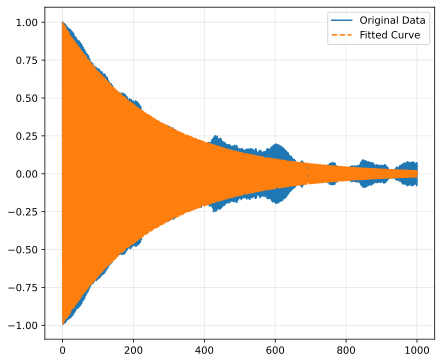

In [63]:

from scipy.optimize import curve_fit

# Define the fitting function
def fit_func(t, gamma, w):
    return np.exp(-gamma * t) * np.cos(w * t)

# Initial guess for parameters
initial_guess = [0, 1.1* 2 * np.pi]

# Perform the curve fitting
params, params_covariance = curve_fit(fit_func, t_list, result[:,-1], p0=initial_guess)

# Extract the fitted parameters
gamma_fit, w_fit = params

# Print the fitted parameters
print(f"Fitted gamma: {gamma_fit}")
print(f"Fitted w: {w_fit}")

# Plot the original data and the fitted curve
plt.figure(figsize=(7, 6))
plt.plot(t_list, result[:,-1], label='Original Data')
plt.plot(t_list, fit_func(t_list, gamma_fit, w_fit), label='Fitted Curve', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [64]:
8.673448076784469/2/np.pi

1.3804221350711412

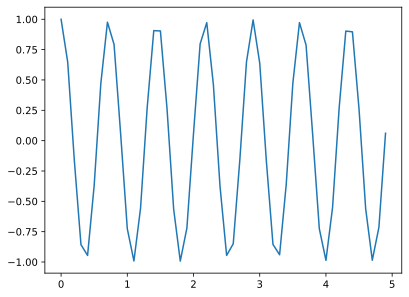

In [65]:
plt.plot(t_list[0:50], result[:,-1][0:50], label='Original Data')